# The Battle of Neighborhioods--Week 2

## Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project, we would compare two most populated Boroughs in the city of Toronto.Specifically, the report is for a friend who is hoping to leave **Toronto Islands** in **downtown 
toronto** ( the most populated borough in toronto) for an undecided place but would like to go for a place similar to where he currently stays i.e. The city must be similar to **Toronto Island** and must in the same capital city of Toronto.

Also, we would also like to find the optimal location for a new **restaurant**. Our location of interest is a **densely populated area** with **few restaurans or no restaurant**.

I will utilize the data scientist skills to explore Toronto neighborhood datasets and extract the needed information.Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

## Data <a name="data"></a>

**Based on my problem definition, the factors that I will consider in making my decisions include the following;**
* Top 20 neighborhoods with the highest number of restaurant
* Top 5 resturants in the selected neighborhoods
* Population of boroughs and their neighborhoods

**The dataset used for my analysis are found in the links below;**
* Canada data: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M
* Population Information: https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/Table.cfm?Lang=Eng&T=1201&SR=1&S=22&O=A&RPP=9999&PR=0
* Geocoordinates of Canada by Postal codes: http://cocl.us/Geospatial_data
 
* I will use the foursquare API to explore neighborhoods and K-means to cluster and segment neighborhoods



## Methodology <a name="methodology"></a>

* I will use pandas to scrape and explore the Canada dataset, an html file that contains Canada postcode, borough, and neighborhoods. 
* I will also scrape the Canadian population information html file and merged it with the previous data frame. 
* I will extract the top two populated boroughs in the data frame and utilize foursquare API to explore each of their neighborhoods. 
* I will use K-means to cluster and segment their neighborhoods into 5 clusters and visualize the cluster on a Map of Toronto using the Folium Library.
* I will also explore the top 20 neighborhoods with the highest number of restaurants using the foursquare API and visualize on a horizontal bar graph.
* I will check for the top 5 restaurants in the neighborhoods and will give suggestions based on results


In [253]:
#import numpy and pandas libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import folium libraries
! pip install folium
import folium

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

In [322]:
#scrape Canada html data from web
html_doc = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
df_Canada = pd.read_html(html_doc, header=0)
df_Can = df_Canada[0]
df_Can.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


### Data Cleaning 

In [323]:
# Select the rows whose Borough is not "Not assigned", then reset the indices
df_Can= df_Can.iloc[:,:][df_Can.iloc[:,1].values != 'Not assigned'].reset_index(drop=True)

In [324]:
#Group the dataframe by Postcode , for multiple Neighborhoods with the same postcode, append their Neighborhoods separated by commas
df_Can_sort=df_Can.groupby("Postcode").agg(lambda x:','.join(set(x))).reset_index('Postcode')


In [325]:
# Replace Neighborhood with 'Not Assigned' values but assigned Boroughhttps://dataplatform.cloud.ibm.com/data/jupyter2/runtimeenv2/v1/wdpx/service/notebook/conda2py3648ce9b975fe04c7cba39b2b167991bfb/dsxjpy/dsCGUEy8AKW-OUfpgCMR2A:bDnO85x7V0Wt-wKin7J3ZRJMQPvrkVgpyUx0aZpS_EPlQTxkONz5pqYmV9JQiZlGqhkTKU8/container/notebooks/487b786f-be32-4502-b74c-42061c77a3d5?api=v2&project=48ce9b97-5fe0-4c7c-ba39-b2b167991bfb#If-a-cell-has-a-borough-but-a-Not-assigned-neighborhood,-then-the-neighborhood-will-be-the-same-as-the-borough
for i in range(103):
    if df_Can_sort.loc[i,'Neighbourhood'] == 'Not assigned':
        df_Can_sort.replace(to_replace=df_Can_sort.loc[i,'Neighbourhood'], value =df_Can_sort.loc[i,'Borough'], inplace=True)

In [326]:
# Print the shape of the resulting dataframe
print(df_Can_sort.shape)

(103, 3)


In [327]:
#print first five rows of the resulting dataframe
df_Can_sort.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern,Rouge"
1,M1C,Scarborough,"Highland Creek,Port Union,Rouge Hill"
2,M1E,Scarborough,"Morningside,Guildwood,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [328]:
# Scrape the canadian population information on the web and read into a dataframe
html ="https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/Table.cfm?Lang=Eng&T=1201&SR=1&S=22&O=A&RPP=9999&PR=0"
df_Canada_Population = pd.read_html(html, header=0)[0]
df_Canada_Population.head()

,Geographic name,"Population, 2016","Total private dwellings, 2016","Private dwellings occupied by usual residents, 2016"
0,NaN,NaN,NaN,NaN
1,CanadaFootnote 1,35151728.0,15412443.0,14072079.0
2,A0A,46587.0,26155.0,19426.0
3,A0B,19792.0,13658.0,8792.0
4,A0C,12587.0,8010.0,5606.0


In [329]:
# merge dataframe with population with Canada neighborhoods
df_Canada=df_Can_sort.merge(df_Canada_Population, left_on='Postcode',right_on='Geographic name')
df_Canada.drop(columns = ['Geographic name','Total private dwellings, 2016','Private dwellings occupied by usual residents, 2016'], inplace=True)
df_Canada.head()

,Postcode,Borough,Neighbourhood,"Population, 2016"
0,M1B,Scarborough,"Malvern,Rouge",66108.0
1,M1C,Scarborough,"Highland Creek,Port Union,Rouge Hill",35626.0
2,M1E,Scarborough,"Morningside,Guildwood,West Hill",46943.0
3,M1G,Scarborough,Woburn,29690.0
4,M1H,Scarborough,Cedarbrae,24383.0


In [330]:
# Rename column "Population,2016" as Population
df_Canada=df_Canada.rename({'Population, 2016':'Population'}, axis=1)
df_Canada.head()

,Postcode,Borough,Neighbourhood,Population
0,M1B,Scarborough,"Malvern,Rouge",66108.0
1,M1C,Scarborough,"Highland Creek,Port Union,Rouge Hill",35626.0
2,M1E,Scarborough,"Morningside,Guildwood,West Hill",46943.0
3,M1G,Scarborough,Woburn,29690.0
4,M1H,Scarborough,Cedarbrae,24383.0


In [331]:
#Read geographical coordinates of each postcode
geo_data = pd.read_csv('http://cocl.us/Geospatial_data', header=0)
geo_data.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [332]:
# merge postal codes to the dataframe 
df_CANADA =df_Canada.merge(geo_data, left_on ='Postcode', right_on='Postal Code').drop(columns=['Postcode','Postal Code']).sort_values('Population', ascending=False).reset_index(drop=True)
df_CANADA.head()

,Borough,Neighbourhood,Population,Latitude,Longitude
0,North York,Willowdale South,75897.0,43.770120,-79.408493
1,Scarborough,"Malvern,Rouge",66108.0,43.806686,-79.194353
2,North York,"Henry Farm,Fairview,Oriole",58293.0,43.778517,-79.346556
3,Etobicoke,"Mount Olive,Albion Gardens,Jamestown,Beaumond ...",55959.0,43.739416,-79.588437
4,Scarborough,"L'Amoreaux East,Steeles East,Milliken,Agincour...",54680.0,43.815252,-79.284577


In [333]:
#check the size of the dataframe
df_CANADA.shape

(102, 5)

In [334]:
#Loop through the dataframe , generating dataset whose Borough include the word 'Toronto'
index =list()
for i in range (102):
    if 'Toronto' in df_CANADA.iloc[i,0]:
        index.append(i)
Toronto_Neigh= df_CANADA.loc[index].reset_index(drop=True)
Toronto_Neigh.head()

,Borough,Neighbourhood,Population,Latitude,Longitude
0,Downtown Toronto,"Bathurst Quay,CN Tower,Railway Lands,South Nia...",49195.0,43.628947,-79.394420
1,West Toronto,"Dufferin,Dovercourt Village",44950.0,43.669005,-79.442259
2,Downtown Toronto,"Regent Park,Harbourfront",41078.0,43.654260,-79.360636
3,West Toronto,"Parkdale Village,Exhibition Place,Brockton",40957.0,43.636847,-79.428191
4,West Toronto,"High Park,The Junction South",40035.0,43.661608,-79.464763


In [335]:
# Sum the population for each borough. Group borough then sum 
df_Pop_Borough=Toronto_Neigh[['Borough','Population']].groupby("Borough").sum().reset_index()
df_Pop_Borough.head()


,Borough,Population
0,Central Toronto,164502.0
1,Downtown Toronto,271186.0
2,East Toronto,113966.0
3,West Toronto,212782.0


In [336]:
#sort borough by population
df_Pop_Borough=df_Pop_Borough.sort_values('Population', ascending=False)
df_Pop_Borough.reset_index(drop=True, inplace=True)
print ('Result shows that the top two most populated Borough in Toronto is ', df_Pop_Borough.loc[0,'Borough'],'and',df_Pop_Borough.loc[1,'Borough'], 'with a population of', df_Pop_Borough.loc[0,'Population'],'and',df_Pop_Borough.loc[1,'Population'],'people respectively' )

df_Pop_Borough.head()



Result shows that the top two most populated Borough in Toronto is  Downtown Toronto and West Toronto with a population of 271186.0 and 212782.0 people respectively


,Borough,Population
0,Downtown Toronto,271186.0
1,West Toronto,212782.0
2,Central Toronto,164502.0
3,East Toronto,113966.0


 As seen above, the result showed that the top two most populated borough in Toronto is Downtown Toronto and West Toronto. We would, therefore , explore both boroughs and their neighborhoods

In [337]:
#Extract data for Downtown Toronto and Neighborhoods
Downtown_Tor= Toronto_Neigh[Toronto_Neigh['Borough']=='Downtown Toronto'].reset_index(drop=True)
Downtown_Tor.head()

,Borough,Neighbourhood,Population,Latitude,Longitude
0,Downtown Toronto,"Bathurst Quay,CN Tower,Railway Lands,South Nia...",49195.0,43.628947,-79.394420
1,Downtown Toronto,"Regent Park,Harbourfront",41078.0,43.654260,-79.360636
2,Downtown Toronto,Christie,32086.0,43.669542,-79.422564
3,Downtown Toronto,Church and Wellesley,30472.0,43.665860,-79.383160
4,Downtown Toronto,"St. James Town,Cabbagetown",20822.0,43.667967,-79.367675


In [338]:
#Extract data for West Toronto and Neighborhoods
West_Tor= Toronto_Neigh[Toronto_Neigh['Borough']=='West Toronto'].reset_index(drop=True)
West_Tor.head()

,Borough,Neighbourhood,Population,Latitude,Longitude
0,West Toronto,"Dufferin,Dovercourt Village",44950.0,43.669005,-79.442259
1,West Toronto,"Parkdale Village,Exhibition Place,Brockton",40957.0,43.636847,-79.428191
2,West Toronto,"High Park,The Junction South",40035.0,43.661608,-79.464763
3,West Toronto,"Swansea,Runnymede",34299.0,43.651571,-79.484450
4,West Toronto,"Trinity,Little Portugal",32684.0,43.647927,-79.419750


### Merge dataset from West Toronto and Downtonwn Toronto

In [339]:
# Cocatenate the dataframes of West Toronto and Downtown Toronto
West_Downtown_Tor = pd.concat([West_Tor, Downtown_Tor], join='inner').reset_index(drop=True)
West_Downtown_Tor.head()

,Borough,Neighbourhood,Population,Latitude,Longitude
0,West Toronto,"Dufferin,Dovercourt Village",44950.0,43.669005,-79.442259
1,West Toronto,"Parkdale Village,Exhibition Place,Brockton",40957.0,43.636847,-79.428191
2,West Toronto,"High Park,The Junction South",40035.0,43.661608,-79.464763
3,West Toronto,"Swansea,Runnymede",34299.0,43.651571,-79.484450
4,West Toronto,"Trinity,Little Portugal",32684.0,43.647927,-79.419750


In [340]:
#Find the size of the combined dataframe
West_Downtown_Tor.shape

(24, 5)

### create map of Toronto then add Downtown Toronto and West Toronto as markers using their latitude and longitude values

In [341]:
#create map of Toronto
Lattitude =43.6532
Longitude=-79.3832
map_Toronto = folium.Map(location=[Lattitude, Longitude], zoom_start=10)

# add Downtown as markers to map
for lat, lng,Neighbor, Population in zip(West_Downtown_Tor['Latitude'],West_Downtown_Tor['Longitude'], West_Downtown_Tor['Neighbourhood'],West_Downtown_Tor['Population']):
    label = '{}, {}'.format(Neighbor,Population)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)
map_Toronto

## Analysis <a name="analysis"></a>

Let's derive additional information from our data. We would explore each neighborhoods and their corresponding top 100 venues

### Define Foursquare credentials

In [275]:
#Define foursquare and credentials
CLIENT_ID = 'LZEBYWWCUISPAR5S5RTTIHWSJNDQ3U5PD3ZC2OXL5KFPPSIH' # your Foursquare ID
CLIENT_SECRET = '4LIBPW5WOEDTXLYJ4EWK31VECFU0EKCRLPLZTXB515JUDUK1' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: LZEBYWWCUISPAR5S5RTTIHWSJNDQ3U5PD3ZC2OXL5KFPPSIH
CLIENT_SECRET:4LIBPW5WOEDTXLYJ4EWK31VECFU0EKCRLPLZTXB515JUDUK1


### Explore top 100 venues in all neighborhoods in the dataframe

Firstly,Let's define a function to extract the top 100 venues in each neighborhoods

In [276]:
#create a function that returns the top 100 venues in all neighborhoods in a Borough
LIMIT=100 # limit of number of venues returned by Foursquare API
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [277]:
# Get the venues for the combined dataframes
West_Downtown_Tor_venues = getNearbyVenues(names=West_Downtown_Tor['Neighbourhood'],
                                   latitudes=West_Downtown_Tor['Latitude'],
                                   longitudes=West_Downtown_Tor['Longitude']
                                )

Dufferin,Dovercourt Village
Parkdale Village,Exhibition Place,Brockton
High Park,The Junction South
Swansea,Runnymede
Trinity,Little Portugal
Roncesvalles,Parkdale
Bathurst Quay,CN Tower,Railway Lands,South Niagara,Harbourfront West,King and Spadina,Island airport
Regent Park,Harbourfront
Christie
Church and Wellesley
St. James Town,Cabbagetown
Chinatown,Kensington Market,Grange Park
Harbord,University of Toronto
Rosedale
Union Station,Toronto Islands,Harbourfront East
Ryerson,Garden District
Berczy Park
Central Bay Street
St. James Town
Adelaide,Richmond,King
Stn A PO Boxes 25 The Esplanade
First Canadian Place,Underground city
Commerce Court,Victoria Hotel
Design Exchange,Toronto Dominion Centre


In [278]:
#Get the size of the venues
West_Downtown_Tor_venues.shape

(1483, 7)

### Let's check how many venues were returned for each neighborhood

In [343]:
#Count the number of venues by neighborhoods
West_Downtown_most_venues=West_Downtown_Tor_venues.groupby('Neighbourhood').count()
West_Downtown_most_venues

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
"Adelaide,Richmond,King",100,100,100,100,100,100
"Bathurst Quay,CN Tower,Railway Lands,South Niagara,Harbourfront West,King and Spadina,Island airport",17,17,17,17,17,17
Berczy Park,57,57,57,57,57,57
Central Bay Street,88,88,88,88,88,88
"Chinatown,Kensington Market,Grange Park",100,100,100,100,100,100
Christie,16,16,16,16,16,16
Church and Wellesley,87,87,87,87,87,87
"Commerce Court,Victoria Hotel",100,100,100,100,100,100
"Design Exchange,Toronto Dominion Centre",100,100,100,100,100,100


In [345]:
#Sort dataframe by venues in descending order
West_Downtown_most_venues_sorted= West_Downtown_most_venues.sort_values('Venue', ascending=False)
# Since the max is 100 , we print dataframe with venues equal to the maximum values
West_Downtown_most_venues_sorted= West_Downtown_most_venues[West_Downtown_most_venues['Venue']==100]
West_Downtown_most_venues_sorted

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
"Adelaide,Richmond,King",100,100,100,100,100,100
"Chinatown,Kensington Market,Grange Park",100,100,100,100,100,100
"Commerce Court,Victoria Hotel",100,100,100,100,100,100
"Design Exchange,Toronto Dominion Centre",100,100,100,100,100,100
"First Canadian Place,Underground city",100,100,100,100,100,100
"Ryerson,Garden District",100,100,100,100,100,100
St. James Town,100,100,100,100,100,100
"Union Station,Toronto Islands,Harbourfront East",100,100,100,100,100,100


In [346]:
# Let's find out how many unique categories can be curated from all the returned venues for West Toronto and Downotown Toronto
print('There are {} uniques categories for Downtown & Western Toronto.'.format(len(West_Downtown_Tor_venues['Venue Category'].unique())))

There are 224 uniques categories for Downtown & Western Toronto.


In [347]:
# Display the first five venues
West_Downtown_Tor_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Dufferin,Dovercourt Village",43.669005,-79.442259,The Greater Good Bar,43.669409,-79.439267,Bar
1,"Dufferin,Dovercourt Village",43.669005,-79.442259,Parallel,43.669516,-79.438728,Middle Eastern Restaurant
2,"Dufferin,Dovercourt Village",43.669005,-79.442259,Happy Bakery & Pastries,43.667050,-79.441791,Bakery
3,"Dufferin,Dovercourt Village",43.669005,-79.442259,Planet Fitness Toronto Galleria,43.667588,-79.442574,Gym / Fitness Center
4,"Dufferin,Dovercourt Village",43.669005,-79.442259,Blood Brothers Brewing,43.669944,-79.436533,Brewery


### Let's find all venues that are restaurants in the neighborhood
 

In [356]:
# Extract dataframe where restaurant is the popular spot in Venue Category
West_Downtown_Tor_venues_Restaurant = West_Downtown_Tor_venues[West_Downtown_Tor_venues['Venue Category'].str.contains('Restaurant')].reset_index(drop=True)
West_Downtown_Tor_venues_Restaurant.index = np.arange(1, len(West_Downtown_Tor_venues_Restaurant)+1)
print ('The size of the dataframe is',West_Downtown_Tor_venues_Restaurant.shape )
West_Downtown_Tor_venues_Restaurant.head()

The size of the dataframe is (357, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,"Dufferin,Dovercourt Village",43.669005,-79.442259,Parallel,43.669516,-79.438728,Middle Eastern Restaurant
2,"Dufferin,Dovercourt Village",43.669005,-79.442259,Stop BBQ Chicken,43.665923,-79.438042,Brazilian Restaurant
3,"Parkdale Village,Exhibition Place,Brockton",43.636847,-79.428191,Island Foods,43.639082,-79.426835,Caribbean Restaurant
4,"Parkdale Village,Exhibition Place,Brockton",43.636847,-79.428191,Caffino,43.639021,-79.425289,Italian Restaurant
5,"Parkdale Village,Exhibition Place,Brockton",43.636847,-79.428191,Vogue Supper Club,43.636951,-79.425446,Restaurant


In [349]:
## Visualize the most visited restaurant in West and Downtown Borough on the map of Toronto
Lattitude =43.6532
Longitude=-79.3832
#create map of Toronto

# add Downtown as markers to map
for lat, lng,Neighbor, Category in zip(West_Downtown_Tor_venues_Restaurant['Venue Latitude'],West_Downtown_Tor_venues_Restaurant['Venue Longitude'],West_Downtown_Tor_venues_Restaurant['Neighbourhood'],West_Downtown_Tor_venues_Restaurant['Venue Category']):
    label = '{}, {}'.format(Neighbor,Category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Restaurant_map)
Restaurant_map

### Group neighborhoods based on their number of venues in the resturant category

We want to know the top 20 neighborhoods with the highest number of restaurant venues

In [357]:
# Extract top 20 neighborhoods with the highest number of restaurants
Top10_Neighbor_with_highest_restaurant = West_Downtown_Tor_venues_Restaurant[['Neighbourhood','Venue']].groupby('Neighbourhood').count()
Top10_Neighbor_with_highest_restaurant=Top10_Neighbor_with_highest_restaurant.sort_values('Venue', ascending=False).head(20)
Top10_Neighbor_with_highest_restaurant

,Venue
Neighbourhood,
"Chinatown,Kensington Market,Grange Park",34
"Adelaide,Richmond,King",30
Church and Wellesley,29
"First Canadian Place,Underground city",26
Central Bay Street,25
"Commerce Court,Victoria Hotel",25
"Ryerson,Garden District",23
St. James Town,23
"Design Exchange,Toronto Dominion Centre",22


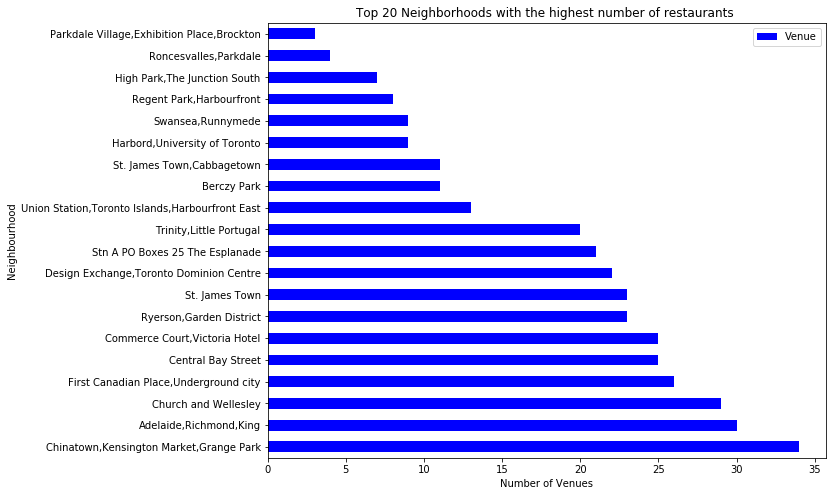

In [358]:
# Plot an horizontal bar graphh to visualize the resulting dataframe
Top10_Neighbor_with_highest_restaurant.plot(kind='barh', figsize=(10, 8), align='center', color='blue')
plt.ylabel('Neighbourhood')
plt.xlabel('Number of Venues')
plt.title('Top 20 Neighborhoods with the highest number of restaurants ')
plt.show()

                                                            Fig. 1

We can see than Chinatown,Kensington Market and Grange Park neighborhood altogether have the highest number of restaurants . I would choose Union Station, Toronto Islands, Harbourfront East as the area I would like to explore for the restaurant opportunties. One of the reason is because it has fewer restaurants and also a busy place. We could see that despite having more venues within the neighborhoods, restaurants are fewer. This could mean that the neighborhoods is a busy type and has a high viability for business. We would explore the Nieghborhood further to have more information.

But before then,
### We would  like to know the top 5 biggest restaurant types in West and Downtown Toronto

In [359]:
# get the top 5 restaurants
West_Downtown_Tor_venues_Restaurant=West_Downtown_Tor_venues_Restaurant[['Venue','Venue Category']].groupby('Venue Category').count().reset_index().sort_values('Venue', ascending=False)
Top_5_Restaurant = West_Downtown_Tor_venues_Restaurant.head()


In [360]:
# Set the venue catergory as index
Top_5_Restaurant = Top_5_Restaurant.set_index('Venue Category')
Top_5_Restaurant

,Venue
Venue Category,
Restaurant,45
Italian Restaurant,40
Japanese Restaurant,23
Seafood Restaurant,21
American Restaurant,19


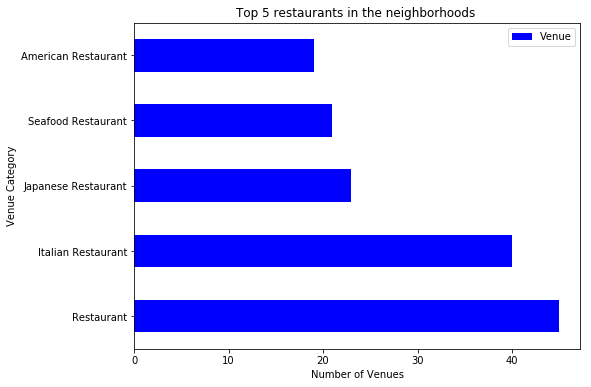

In [361]:
# Plot sn horizontal bar graphh to visualize the resulting dataframe
Top_5_Restaurant.plot(kind='barh', figsize=(8, 6), align='center', color='blue')
plt.ylabel('Venue Category')
plt.xlabel('Number of Venues')
plt.title('Top 5 restaurants in the neighborhoods ')
plt.show()

                                       Fig. 2
The chart above shows that italian restaurants has the greatest number of traffics. Although we saw "Restaurant" with the greatest number of traffic, I will neglect that because our data does not specify the type of restuarant it is.

In [362]:
# one hot encoding
West_Downtown_Tor_onehot = pd.get_dummies(West_Downtown_Tor_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
West_Downtown_Tor_onehot['Neighbourhood'] = West_Downtown_Tor_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [West_Downtown_Tor_onehot.columns[-1]] + list(West_Downtown_Tor_onehot.columns[:-1])
West_Downtown_Tor_onehot = West_Downtown_Tor_onehot[fixed_columns]

West_Downtown_Tor_onehot.head()

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Dufferin,Dovercourt Village",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Dufferin,Dovercourt Village",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Dufferin,Dovercourt Village",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Dufferin,Dovercourt Village",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Dufferin,Dovercourt Village",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [363]:
# let's examine the new dataframe size.
West_Downtown_Tor_onehot.shape

(1483, 225)

In [364]:
#Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
West_Downtown_Tor_grouped = West_Downtown_Tor_onehot.groupby('Neighbourhood').mean().reset_index()
West_Downtown_Tor_grouped

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide,Richmond,King",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,...,0.0,0.00,0.020000,0.000000,0.000000,0.000000,0.010000,0.000000,0.01,0.000000
1,"Bathurst Quay,CN Tower,Railway Lands,South Nia...",0.000000,0.058824,0.058824,0.058824,0.117647,0.176471,0.117647,0.000000,0.000000,...,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
2,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.00,0.017544,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
3,Central Bay Street,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011364,0.000000,...,0.0,0.00,0.011364,0.000000,0.011364,0.000000,0.011364,0.000000,0.00,0.011364
4,"Chinatown,Kensington Market,Grange Park",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.00,0.050000,0.000000,0.000000,0.040000,0.010000,0.000000,0.00,0.000000
5,Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
6,Church and Wellesley,0.011494,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011494,0.000000,...,0.0,0.00,0.000000,0.011494,0.000000,0.000000,0.000000,0.011494,0.00,0.011494
7,"Commerce Court,Victoria Hotel",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,...,0.0,0.00,0.020000,0.000000,0.000000,0.000000,0.010000,0.000000,0.00,0.000000
8,"Design Exchange,Toronto Dominion Centre",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,...,0.0,0.01,0.010000,0.000000,0.000000,0.000000,0.010000,0.000000,0.00,0.000000
9,"Dufferin,Dovercourt Village",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000


In [365]:
# Confirm the new size
West_Downtown_Tor_grouped.shape

(24, 225)

### Let's print each neighborhood along with the top 5 most common venues


In [366]:
num_top_venues = 5

for hood in West_Downtown_Tor_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = West_Downtown_Tor_grouped[West_Downtown_Tor_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide,Richmond,King----
                 venue  freq
0          Coffee Shop  0.07
1                 Café  0.05
2      Thai Restaurant  0.04
3                  Bar  0.04
4  American Restaurant  0.04


----Bathurst Quay,CN Tower,Railway Lands,South Niagara,Harbourfront West,King and Spadina,Island airport----
              venue  freq
0   Airport Service  0.18
1    Airport Lounge  0.12
2  Airport Terminal  0.12
3          Boutique  0.06
4           Airport  0.06


----Berczy Park----
            venue  freq
0     Coffee Shop  0.07
1    Cocktail Bar  0.05
2  Farmers Market  0.04
3      Steakhouse  0.04
4        Beer Bar  0.04


----Central Bay Street----
                venue  freq
0         Coffee Shop  0.15
1  Italian Restaurant  0.07
2                Café  0.05
3      Ice Cream Shop  0.03
4        Burger Joint  0.03


----Chinatown,Kensington Market,Grange Park----
                           venue  freq
0                           Café  0.06
1             Chinese Restaurant  0.0

The result above shows the top 5 venues in each of the neighborhoods. We can see that the **Union Station,Toronto Islands,Harbourfront East** that I chose as the prospective resturant venue has no **restaurant** in its top 5 venues. The shows that probability for competition will be less if a **new restaurant** is brought to the neighborhood

### Let's put the results into a dataframe

In [367]:
#First, let's write a function to sort the venues in descending order.

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [368]:
# Now let's create the new dataframe and display the top 10 venues for each neighborhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = West_Downtown_Tor_grouped['Neighbourhood']

for ind in np.arange(Downtown_Tor_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(West_Downtown_Tor_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = West_Downtown_Tor_grouped['Neighbourhood']

for ind in np.arange(West_Downtown_Tor_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(West_Downtown_Tor_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide,Richmond,King",Coffee Shop,Café,American Restaurant,Thai Restaurant,Bar,Steakhouse,Burger Joint,Hotel,Restaurant,Asian Restaurant
1,"Bathurst Quay,CN Tower,Railway Lands,South Nia...",Airport Service,Airport Lounge,Airport Terminal,Boutique,Sculpture Garden,Plane,Boat or Ferry,Bar,Harbor / Marina,Airport Gate
2,Berczy Park,Coffee Shop,Cocktail Bar,Cheese Shop,Bakery,Steakhouse,Beer Bar,Seafood Restaurant,Café,Farmers Market,Jazz Club
3,Central Bay Street,Coffee Shop,Italian Restaurant,Café,Sandwich Place,Burger Joint,Ice Cream Shop,Gym / Fitness Center,Salad Place,Chinese Restaurant,Bar
4,"Chinatown,Kensington Market,Grange Park",Café,Chinese Restaurant,Vegetarian / Vegan Restaurant,Bar,Mexican Restaurant,Vietnamese Restaurant,Coffee Shop,Dumpling Restaurant,Bakery,Donut Shop


### Run K-Means to clusters the neighborhoods into 5 clusters

In [369]:
# set number of clusters
kclusters = 5

West_Downtown_Tor_grouped_clustering = West_Downtown_Tor_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(West_Downtown_Tor_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 2, 0, 0, 0, 3, 0, 0, 0, 4], dtype=int32)

### Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood in Downtown Toronto

In [370]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

West_Downtown_Tor_merged = West_Downtown_Tor

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
West_Downtown_Tor_merged = West_Downtown_Tor_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

West_Downtown_Tor_merged.head() # check the last columns!

,Borough,Neighbourhood,Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,West Toronto,"Dufferin,Dovercourt Village",44950.0,43.669005,-79.442259,4,Pharmacy,Bakery,Supermarket,Middle Eastern Restaurant,Music Venue,Park,Pet Store,Café,Brewery,Brazilian Restaurant
1,West Toronto,"Parkdale Village,Exhibition Place,Brockton",40957.0,43.636847,-79.428191,0,Café,Coffee Shop,Breakfast Spot,Pet Store,Sandwich Place,Burrito Place,Restaurant,Caribbean Restaurant,Climbing Gym,Gym
2,West Toronto,"High Park,The Junction South",40035.0,43.661608,-79.464763,0,Mexican Restaurant,Café,Bar,Thai Restaurant,Park,Fried Chicken Joint,Bookstore,Fast Food Restaurant,Flea Market,Cajun / Creole Restaurant
3,West Toronto,"Swansea,Runnymede",34299.0,43.651571,-79.484450,0,Coffee Shop,Café,Sushi Restaurant,Pizza Place,Italian Restaurant,Sandwich Place,Bar,Fish Market,Fish & Chips Shop,Smoothie Shop
4,West Toronto,"Trinity,Little Portugal",32684.0,43.647927,-79.419750,0,Bar,Coffee Shop,Men's Store,Asian Restaurant,French Restaurant,Restaurant,Cocktail Bar,Pizza Place,New American Restaurant,Vietnamese Restaurant


### Finally, let's visualize the resulting clusters superimposed on the map of toronto

In [371]:
# create map
map_Toronto = folium.Map(location=[Lattitude, Longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add downtown toronto clusters as markers on the map of toronto
markers_colors = []
for lat, lon, poi, cluster in zip(West_Downtown_Tor_merged['Latitude'], West_Downtown_Tor_merged['Longitude'], West_Downtown_Tor_merged['Neighbourhood'], West_Downtown_Tor_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_Toronto) 
map_Toronto

## Results and Discussion <a name="results"></a>

**Problem1 : Comparing Neighborhoods in Downtown Toronto and West Toronto**
Results showed that some part of Downtown Toronto has common features to that of West Toronto.We can see that from the above map with the neighborhood clusters, neighborhoods with red markers have similar features and so,  form a cluster. Hence, from the result,It can be said that our neighborhood of interest , Toronto Islands is in the same clusters as Parkdale village , Trinity, Little Portugal and others.Perhaps Tunde ( the stakeholder) might not want to go that far from where he currently stays, he can choose to move to Parkdale or Trinity which seems to be the closest similar neighborhood in distance.

**Problem 2:Recommended location for a restuarant**
From the graph in Fig 1, We can see than Chinatown,Kensington Market and Grange Park neighborhood altogether have the highest number of restaurants . I would choose Union Station, Toronto Islands, Harbourfront East as the area I would like to explore for the restaurant opportunties. One of the reason is because it has fewer restaurants(see Fig. 1) and also a busy place. We could see that despite having more venues within the neighborhoods, restaurants are fewer. This could mean that the neighborhoods is a busy type and has a high viability for business.
To increase the accuracy of my result, It would be nice to get the spending power , wellbeing and demographics of the people in the the top 20 areas with the highest number of restaurants. The chart above has shown that there are more italian restaurants than others in the neighborhoods. Apart from the first " Restaurant" which has no specified demographics, other restaurants are made to serve delicacies for some specific set of people. This doesn't rule out that some americans might also go to italian resturants and so on.Also, among the top 10 most common venues for each neighborhood, every other neighborhoods has more than one restaurant on their list except Toronto Islands which shows that there would be less competition for a new restaurant. Hence, within the scope of my report, I have found Toronto Island neighborhood as a viable place for opening a restaurant.
 We can further explore the the wellbeing , spending power, and perhaps the income of the people in the neighborhood. As written above, we can get the demographics of the people which can help us to refine our resturant type, perhaps, it could be a general purpose restaurant with some italian, chinese or american meals available on request.


In [318]:

West_Downtown_Tor_merged

,Borough,Neighbourhood,Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,West Toronto,"Dufferin,Dovercourt Village",44950.0,43.669005,-79.442259,4,Pharmacy,Bakery,Supermarket,Middle Eastern Restaurant,Music Venue,Park,Pet Store,Café,Brewery,Brazilian Restaurant
1,West Toronto,"Parkdale Village,Exhibition Place,Brockton",40957.0,43.636847,-79.428191,0,Café,Coffee Shop,Breakfast Spot,Pet Store,Sandwich Place,Burrito Place,Restaurant,Caribbean Restaurant,Climbing Gym,Gym
2,West Toronto,"High Park,The Junction South",40035.0,43.661608,-79.464763,0,Mexican Restaurant,Café,Bar,Thai Restaurant,Park,Fried Chicken Joint,Bookstore,Fast Food Restaurant,Flea Market,Cajun / Creole Restaurant
3,West Toronto,"Swansea,Runnymede",34299.0,43.651571,-79.484450,0,Coffee Shop,Café,Sushi Restaurant,Pizza Place,Italian Restaurant,Sandwich Place,Bar,Fish Market,Fish & Chips Shop,Smoothie Shop
4,West Toronto,"Trinity,Little Portugal",32684.0,43.647927,-79.419750,0,Bar,Coffee Shop,Men's Store,Asian Restaurant,French Restaurant,Restaurant,Cocktail Bar,Pizza Place,New American Restaurant,Vietnamese Restaurant
5,West Toronto,"Roncesvalles,Parkdale",19857.0,43.648960,-79.456325,0,Breakfast Spot,Gift Shop,Restaurant,Dessert Shop,Eastern European Restaurant,Bar,Bank,Dog Run,Movie Theater,Italian Restaurant
6,Downtown Toronto,"Bathurst Quay,CN Tower,Railway Lands,South Nia...",49195.0,43.628947,-79.394420,2,Airport Service,Airport Lounge,Airport Terminal,Boutique,Sculpture Garden,Plane,Boat or Ferry,Bar,Harbor / Marina,Airport Gate
7,Downtown Toronto,"Regent Park,Harbourfront",41078.0,43.654260,-79.360636,0,Coffee Shop,Park,Bakery,Pub,Café,Mexican Restaurant,Breakfast Spot,Theater,Restaurant,Historic Site
8,Downtown Toronto,Christie,32086.0,43.669542,-79.422564,3,Café,Grocery Store,Park,Nightclub,Diner,Italian Restaurant,Baby Store,Restaurant,Athletics & Sports,Coffee Shop
9,Downtown Toronto,Church and Wellesley,30472.0,43.665860,-79.383160,0,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Restaurant,Gay Bar,Gastropub,Men's Store,Mediterranean Restaurant,Hotel,Gym


## Conclusion <a name="conclusion"></a>

The first part of the project is to identify similar neighborhood for a friend who intends to leave Toronto Islands in downtown toronto to seek for a similar environment.I was able to identify a neighborhood with a similar feature by k-means clustering. With the stakeholder also considering a little densely populated neighborhood, I considered the next-in-line city after downtown Toronto in terms of population and further did an exploratory analysis of its neighborhoods. Also, I considered the top 20 neighborhoods with the highest number of restaurants and the top 5 restaurants in the neighborhoods. I realized a distinct neighborhood (Toronto Island) location with an opportunity, because despite having more venues than most neighborhoods, there are fewer restaurants.Based on my result, I suggested that the stakeholder should consider a general purpose restaurant , and not the one made for a particular demographics. I believe that will increase the restaurant chance of exploiting consumer opporunities.I believe having additional information like population demographics, wellbeing, income per household & spending power of the people in the neighborhood would have a great impact on the project.


Thanks for your time.
